Importing Python Libraries

In [60]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Read data files using pandas
- Load data to the dataframe object

In [61]:
medical_notes = pd.read_csv(r"C:\Users\61102\PSU-PhD\Holmusk\ClinNotes.csv")

In [62]:
medical_notes.describe()

,category,notes
count,818,818
unique,3,812
top,Cardiovascular / Pulmonary,"DIAGNOSES ON ADMISSION,1. Cerebrovascular acc..."
freq,371,2


In [63]:
medical_notes.groupby("category").count()

,notes
category,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223


In [64]:
medical_notes['category'].replace({'Cardiovascular / Pulmonary': 1, 'Neurology': 2, 'Gastroenterology': 3},inplace=True)

In [65]:
medical_notes.head()

,category,notes
0,1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,1,1. The left ventricular cavity size and wall ...
2,1,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,1,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,1,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [66]:
medical_notes.groupby("category").count()

,notes
category,
1,371
2,223
3,224


Text Preprocessing
- Change all letters to the lowecase
- Remove white spaces

In [67]:
# Function to preprocess notes
# Conversion to lowecase letters
# White space removal
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.strip()
    return df

#Preprocessing notes
medical_notes = standardize_text(medical_notes, "notes")


Tokenization
- tokenize the notes into work tokens using NLTK regex tokenizer (by whitespace)

In [68]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

medical_notes["tokens"] = medical_notes["notes"].apply(tokenizer.tokenize)
medical_notes.head()

,category,notes,tokens
0,1,"2-d m-mode: , ,1. left atrial enlargement wit...","[2, d, m, mode, 1, left, atrial, enlargement, ..."
1,1,1. the left ventricular cavity size and wall ...,"[1, the, left, ventricular, cavity, size, and,..."
2,1,"2-d echocardiogram,multiple views of the heart...","[2, d, echocardiogram, multiple, views, of, th..."
3,1,"description:,1. normal cardiac chambers size....","[description, 1, normal, cardiac, chambers, si..."
4,1,"2-d study,1. mild aortic stenosis, widely calc...","[2, d, study, 1, mild, aortic, stenosis, widel..."


In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in medical_notes["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in medical_notes["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

371028 words total, with a vocabulary size of 13626
Max sentence length is 2583


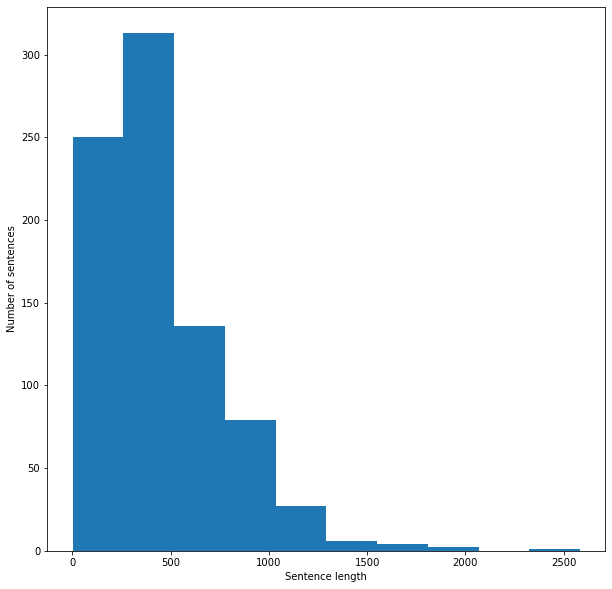

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Bag-of-Words (BOW)
- sparse vector representation of words

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = medical_notes["notes"].tolist()
list_labels = medical_notes["category"].tolist()

#split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [72]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Cardiovascular / Pulmonary')
            blue_patch = mpatches.Patch(color='blue', label='Neurology')
            green_patch = mpatches.Patch(color='green', label='Gastroenterology')
            plt.legend(handles=[orange_patch, blue_patch, green_patch], prop={'size': 30})

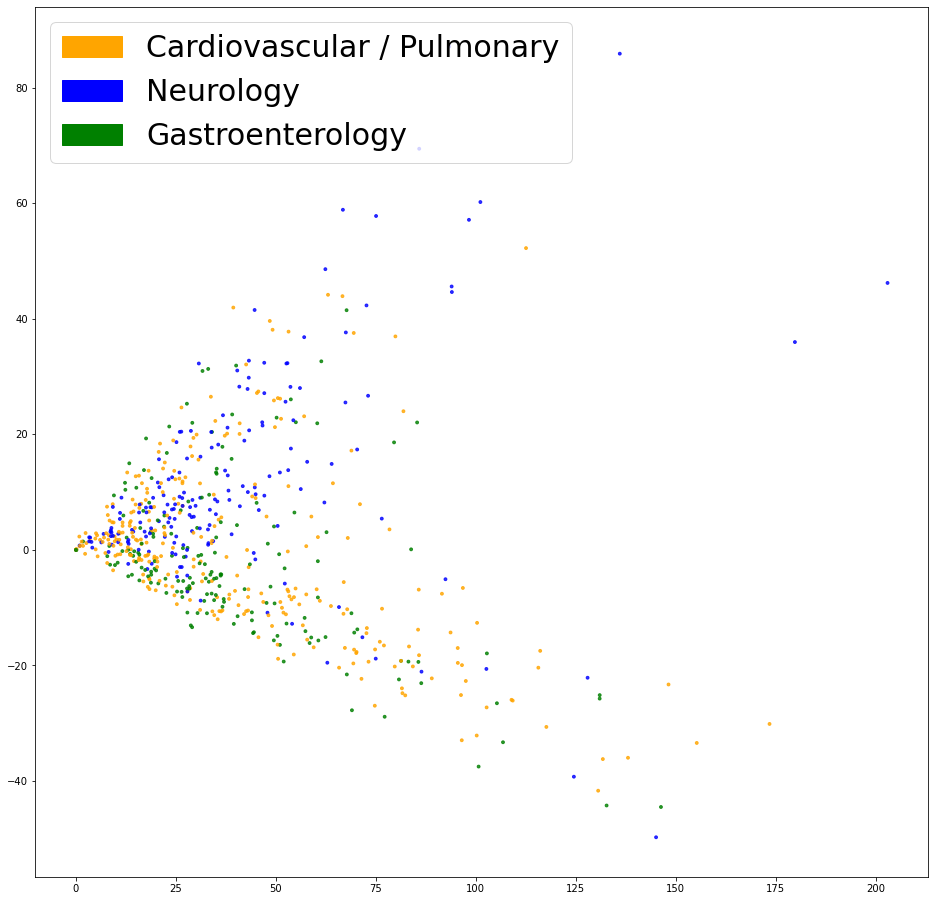

In [73]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [75]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.884, precision = 0.890, recall = 0.884, f1 = 0.882


TF-IDF BOW
- weighted sparse vector representation of words
- numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus

In [76]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

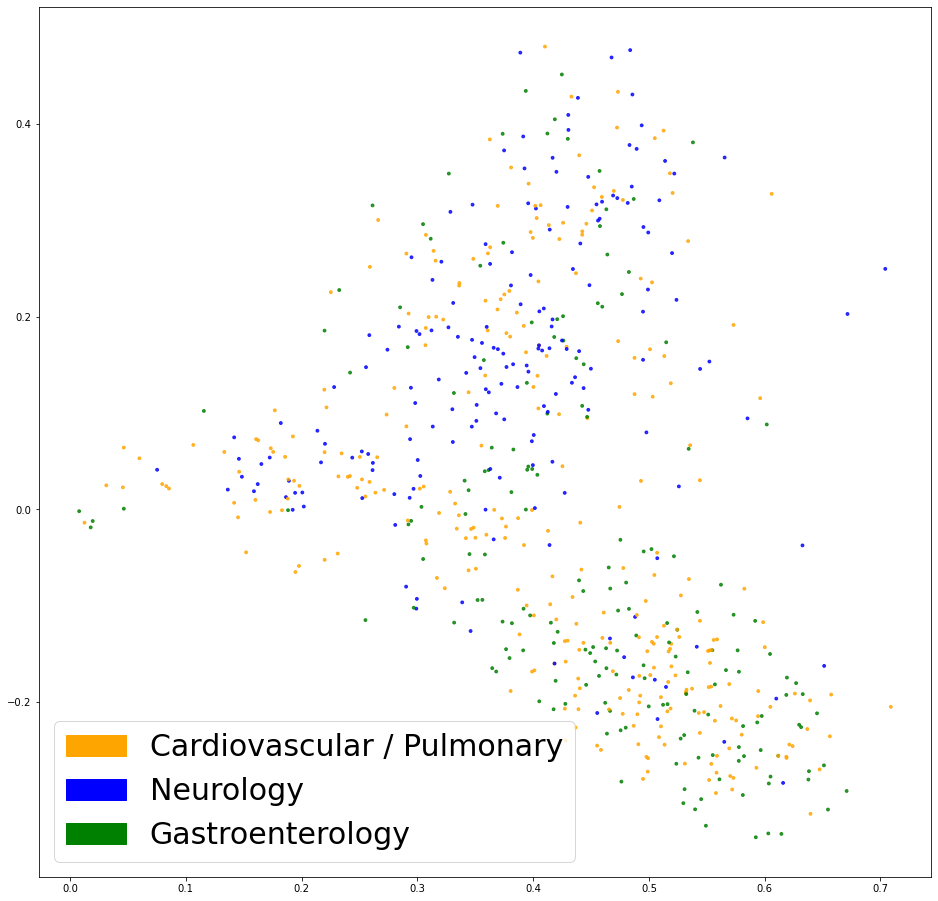

In [77]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [78]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.921, precision = 0.924, recall = 0.921, f1 = 0.920


In [79]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

Word2Vec Embedding
- dense vector representation words
- can capture semantic relation between words
- learnt by a shallow neural network model
- Skip-Gram model which is part of the Word2Vec library. It was created by a team of researchers led by Tomas Mikolov at Google. The main idea is to represent words by means of its neighbors. It tries to predict all neighboring words(the context) of a given word.

Reference Paper: https://arxiv.org/abs/1301.3781

In [82]:
import gensim

word2vec_path = word2vec_path = r"C:\Users\61102\PSU-PhD\Holmusk\Retrofiited Vectors\ClinNotes_w2v-retrofit.txt"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=False, no_header=True)

In [85]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [86]:
embeddings = get_word2vec_embeddings(word2vec, medical_notes)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

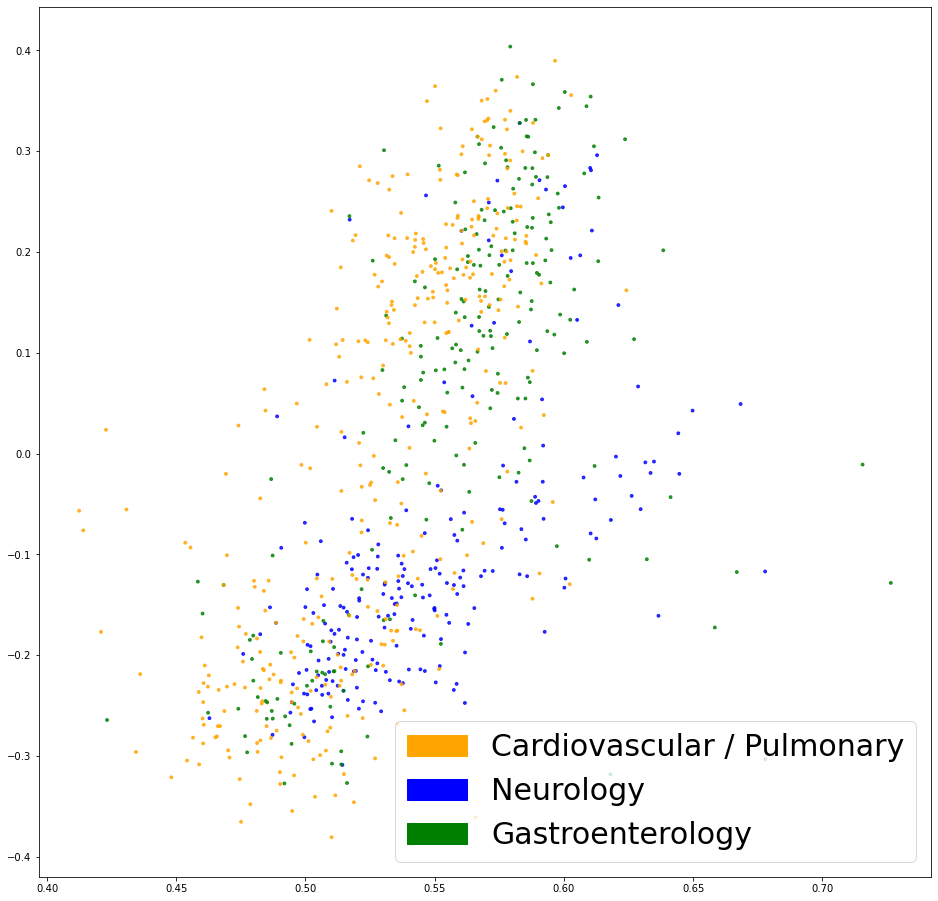

In [87]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [88]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)

y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.622, precision = 0.642, recall = 0.622, f1 = 0.625


In [89]:
cm = confusion_matrix(y_test, y_predicted_word2vec)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=[1,2,3], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Word2Vec Semantic Similarity Analysis

In [ ]:
word2vec.most_similar(positive=['diabetes'], topn = 20)